In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
# 设置 Matplotlib 支持中文
matplotlib.rc("font", family="SimHei")  # 使用黑体
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

## 区域划分

In [3]:
data = pd.read_csv('../data/深圳市定点零售药品名单_包含坐标.csv')
medicine_shop = pd.read_csv('../data/深圳市定点零售药品名单_包含坐标.csv')
center = pd.read_csv('../data/深圳市药品配送中心.csv',encoding='gbk')
center.head(2)

,配送中心,X,Y
0,九州通,114.380103,22.687209
1,国药物流,114.032279,22.760200


### 数据清洗

In [4]:
# 洗掉坐标为（0,0）的数据
medicine_shop = medicine_shop[(medicine_shop['X'] != 0) & (medicine_shop['Y'] != 0)].dropna()
center = center[(center['X'] != 0) & (center['Y'] != 0)].dropna()

In [5]:
# 提取经纬度
shop_locations = medicine_shop[['X', 'Y']].values
center_locations = center[['X', 'Y']].values

In [6]:
# 设置 KMeans，指定初始聚类中心
kmeans = KMeans(n_clusters=len(center_locations), init=center_locations, n_init=1, max_iter=300)
medicine_shop['Cluster'] = kmeans.fit_predict(shop_locations)

In [7]:
# 计算评估指标
sse = kmeans.inertia_
silhouette_avg = silhouette_score(shop_locations, medicine_shop['Cluster'])
db_index = davies_bouldin_score(shop_locations, medicine_shop['Cluster'])

In [8]:
print(f"SSE: {sse:.2f}")
print(f"Silhouette Score: {silhouette_avg:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")

SSE: 42.31
Silhouette Score: 0.46
Davies-Bouldin Index: 0.80


D:\Temp\ipykernel_3460\2481504221.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(center_coords))  # 生成不同颜色
D:\Temp\ipykernel_3460\2481504221.py:31: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(center.iloc[i]['X'], center.iloc[i]['Y'],


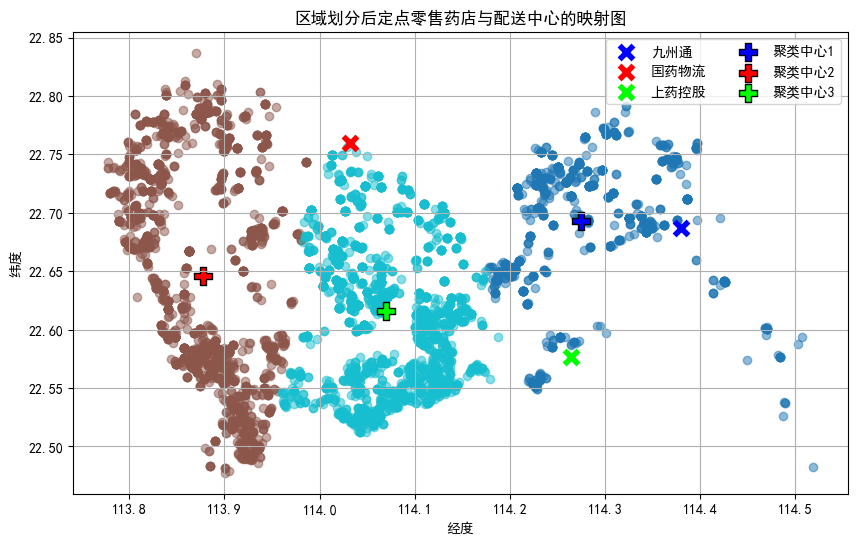

In [9]:
# 去除 X, Y 值为 0 的数据
medicine_shop = medicine_shop[(medicine_shop["X"] != 0) & (medicine_shop["Y"] != 0)]
center = center[(center["X"] != 0) & (center["Y"] != 0)]

# 提取坐标
shop_coords = medicine_shop[["X", "Y"]].values
center_coords = center[["X", "Y"]].values

# 使用配送中心作为初始聚类中心
kmeans = KMeans(n_clusters=len(center_coords), init=center_coords, n_init=1, random_state=42)
labels = kmeans.fit_predict(shop_coords)
cluster_centers = kmeans.cluster_centers_

# 画图
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap("tab10", len(center_coords))  # 生成不同颜色

# color_list = ["#00008B", "#8B4513", "#20B2AA"]
color_list = ["#0000FF", "#FF0000", "#00FF00"]

for i in range(len(center_coords)):
    # 获取属于第 i 簇的点阿
    cluster_points = shop_coords[labels == i]
    
    # 画聚类点（小圆点 'o'）
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                color=colors(i), alpha=0.5)

# 配送中心
for i in range(len(center)):
    plt.scatter(center.iloc[i]['X'], center.iloc[i]['Y'], 
                linewidths=4, marker='x', s=100, alpha=1.0,
                edgecolors="black", c=color_list[i], 
                label=center.iloc[i]['配送中心'])

for i in range(len(center_coords)):
    # 画聚类中心（配送中心更明显）
    plt.scatter(cluster_centers[i, 0], cluster_centers[i, 1], 
                color=color_list[i], marker="P", s=150, edgecolors='black',
                linewidths=1, alpha=1.0, label=f"聚类中心{i+1}")
# 添加图例
plt.xlabel("经度")
plt.ylabel("纬度")
plt.title("区域划分后定点零售药店与配送中心的映射图")
plt.legend(ncol=2)
plt.grid()
plt.show()

## 需求量获取

In [10]:
population = pd.read_csv('./深圳各区人口系数.csv')
season = pd.read_csv('./季节系数.csv', encoding='gbk')

In [11]:
def produce_req(row, population, season):
    base = 1000
    district = row['辖区']
    time = 3

    # 从人口系数表中提取对应区域的建议系数
    pop_coefficient = population.loc[population['区域'] == district, '建议系数']
    if pop_coefficient.empty:
        raise ValueError(f"未找到区域：{district}")

    # 从季节系数表中提取对应月份的系数
    season_coefficient = season.loc[season['月份'] == time, '系数']
    if season_coefficient.empty:
        raise ValueError(f"未找到月份：{time}")

    # 计算需求量
    req = base * pop_coefficient.iloc[0] * season_coefficient.iloc[0] + np.random.normal(loc=200, scale=200)
    return np.floor(req)


In [12]:
medicine_shop['demand'] = medicine_shop.apply(produce_req, axis=1, population=population, season=season)

In [13]:
medicine_shop.head()

,Unnamed: 0,序号,辖区,零售药店代码（国家）,零售药店名称,地址,X,Y,Cluster,demand
0,0,1,南山区,P44030504506,深圳市健华药业连锁有限公司,深圳市南山区桃源街道桃源社区北环大道方大广场（一期）3、4号研发楼3号楼805,113.972673,22.556772,2,1242.0
1,1,2,宝安区,P44030602632,深圳市健华药业连锁有限公司锦花分店,深圳市宝安区西乡街道固戍下围园工业区A栋1F103号,113.844884,22.596670,1,2771.0
2,2,3,宝安区,P44030602643,深圳市健华药业连锁有限公司流塘分店,广东省深圳市宝安区西乡街道流塘社区工业路38号－2,113.885481,22.569978,1,2655.0
3,3,4,宝安区,P44030602642,深圳市健华药业连锁有限公司流塘新村分店,深圳市宝安区西乡街道流塘社区新村6巷9号一楼101铺,113.885680,22.579188,1,2911.0
4,4,5,宝安区,P44030602645,深圳市健华药业连锁有限公司奇生分店,深圳市宝安区西乡街道固戍社区固戍一路849号,113.849231,22.596885,1,2865.0


## VRP建模

### 简单案例

In [14]:
medicine_shop.to_csv('./data.csv')

In [15]:
# 定义载重上限
max_capacity = 40000

data = medicine_shop.sample(100, random_state=42)
df = pd.DataFrame(data)

In [16]:
import pygad

def distance(point1, point2):
    # 将经纬度转换为弧度
    lat1, lon1, lat2, lon2 = map(np.radians, [point1[0], point1[1], point2[0], point2[1]])
        
    # 计算纬度和经度的差值
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
        
    # 应用 Haversine 公式
    a = np.sin(delta_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
        
    # 地球平均半径（公里）
    R = 6371.0
    distance = R * c
        
    return distance

# 解析路径
def parse_route(solution):
    routes = []
    current_route = []
    current_capacity = 0
        
    for idx in solution:
        demand = df.loc[idx, 'demand']
        if current_capacity + demand > max_capacity:
            # 如果超出载重限制，结束当前子路径
            routes.append(current_route)
            current_route = []
            current_capacity = 0
        current_route.append(idx)
        current_capacity += demand
        
        # 添加最后一个子路径
    if current_route:
        routes.append(current_route)
        
    return routes

def ga_vrp(df, num_points, center_x, center_y, name):    

    # 适应度函数：计算路径的总距离，并考虑载重约束
    def fitness_func(ga_instance, solution, solution_idx):
        total_distance = 0
        current_capacity = 0
        current_point = (center_x, center_y)  # 配送中心
        
        for idx in solution:
            idx = int(idx)
            next_point = (df.loc[idx, 'X'], df.loc[idx, 'Y'])
            demand = df.loc[idx, 'demand']
            
            # 检查载重约束
            if current_capacity + demand > max_capacity:
                # 如果超出载重限制，返回到配送中心并重新开始
                total_distance += distance(current_point, (center_x, center_y))
                current_point = (center_x, center_y)
                current_capacity = 0
            
            total_distance += distance(current_point, next_point)
            current_point = next_point
            current_capacity += demand
        
        # 最后返回配送中心
        total_distance += distance(current_point, (center_x, center_y))
        
        # 适应度值为总距离的倒数
        return 1 / (1 + total_distance)

    fitness_history = []
    # 回调函数 记录适应度
    def on_generation(ga_instance):
        # 获取当前代的适应度值
        current_fitness = ga_instance.best_solution()[1]
        # 保存适应度值
        fitness_history.append(current_fitness)

    # 初始化遗传算法
    ga_instance = pygad.GA(num_generations=200,  # 运行200代
                        num_parents_mating=5,  # 每代选择20个父代
                        fitness_func=fitness_func,  # 适应度函数
                        sol_per_pop=100,  # 种群大小为100
                        num_genes=num_points,  # 每个解有num_points个基因
                        init_range_low=0,  # 基因值的最小值为0
                        init_range_high=num_points - 1,  # 基因值的最大值为num_points - 1
                        mutation_percent_genes=20,  # 20%的基因发生变异
                        gene_space=df.index.to_list(),
                        allow_duplicate_genes=False,  # 禁止重复基因
                        crossover_type="single_point",  # 单点交叉
                        mutation_type="swap",
                        on_generation=on_generation)  # 交换变异

    # 运行遗传算法
    ga_instance.run()

    # 输出最优解
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print(f"配送中心：{name}")
    print(f"最优路径: {solution}")
    print(f"适应度值: {solution_fitness}")

    # 输出路径
    routes = parse_route(solution)
    print("车辆路径:")
    for i, route in enumerate(routes):
        print(f"子路径 {i+1}: {route}")

    return fitness_history, routes

In [17]:
_data = []
routes = []

for idx, frame in df.groupby('Cluster'):
    print('-' * 10)
    fn,route = ga_vrp(frame, frame.shape[0], center.loc[idx, 'X'], center.loc[idx, 'Y'], center.loc[idx, '配送中心'])
    _data.append(fn)
    routes.append(route)

fitness_history = _data

----------
配送中心：九州通
最优路径: [4657. 4648. 5305. 4718. 3823. 1918. 3382. 5102. 2145. 1809. 4012. 1764.
 4461. 4811.]
适应度值: 0.010736747614880814
车辆路径:
子路径 1: [4657.0, 4648.0, 5305.0, 4718.0, 3823.0, 1918.0, 3382.0, 5102.0, 2145.0, 1809.0, 4012.0, 1764.0, 4461.0, 4811.0]
----------
配送中心：国药物流
最优路径: [3178. 3050. 3080.   79. 4095. 4138. 4459.  749. 5389.  406.   15. 5001.
 4383.    8. 4793.  233.   84. 1265. 5374. 4272.  426. 3937.  282.  719.
  638.  598.  475. 3495. 4308. 3131.  517. 3890. 1555. 4671. 3489.  169.
 3862. 3054. 3062. 3228.   33.  242. 3493. 4195. 1515. 4197. 4938.]
适应度值: 0.0031856379532621067
车辆路径:
子路径 1: [3178.0, 3050.0, 3080.0, 79.0, 4095.0, 4138.0, 4459.0, 749.0, 5389.0, 406.0, 15.0, 5001.0, 4383.0, 8.0, 4793.0, 233.0, 84.0]
子路径 2: [1265.0, 5374.0, 4272.0, 426.0, 3937.0, 282.0, 719.0, 638.0, 598.0, 475.0, 3495.0, 4308.0, 3131.0, 517.0, 3890.0, 1555.0, 4671.0]
子路径 3: [3489.0, 169.0, 3862.0, 3054.0, 3062.0, 3228.0, 33.0, 242.0, 3493.0, 4195.0, 1515.0, 4197.0, 4938.0]
---------

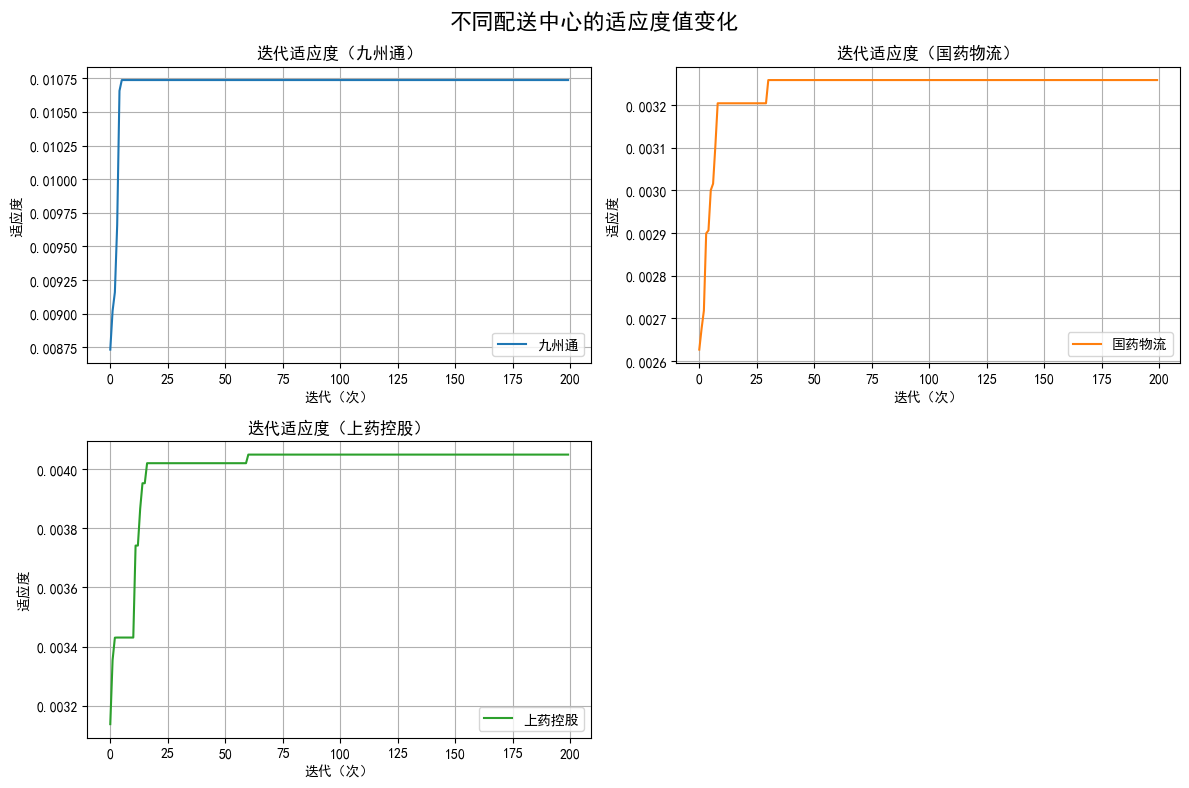

In [18]:
import matplotlib.pyplot as plt
import numpy as np

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# 设置图形大小
plt.figure(figsize=(12, 8))

# 遍历每个配送中心
for i, label in enumerate(center['配送中心'].to_list()):
    plt.subplot(2, 2, i + 1)
    plt.title(f'迭代适应度（{label}）', fontsize=12)
    plt.xlabel('迭代（次）', fontsize=10)
    plt.ylabel('适应度', fontsize=10)
    plt.plot(_data[i], label=f'{label}', c=default_colors[i])
    plt.grid(True)  # 添加网格线
    plt.legend(fontsize=10)

# 添加全局标题
plt.suptitle('不同配送中心的适应度值变化', fontsize=16)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

### 稳定性

In [20]:
# 重复运行十次
stable_f = []
routes = []

for idx, frame in df.groupby('Cluster'):
    t = []
    for i in range(10):
        print('-' * 10)
        fn, _ = ga_vrp(frame, frame.shape[0], center.loc[idx, 'X'], center.loc[idx, 'Y'], center.loc[idx, '配送中心'])
        t.append(fn)
    stable_f.append(t)
stable_f

----------
配送中心：九州通
最优路径: [4718. 4461. 2145. 4012. 5102. 1809. 1918. 4648. 4657. 5305. 4811. 3823.
 1764. 3382.]
适应度值: 0.00857092309114858
车辆路径:
子路径 1: [4718.0, 4461.0, 2145.0, 4012.0, 5102.0, 1809.0, 1918.0, 4648.0, 4657.0, 5305.0, 4811.0, 3823.0, 1764.0, 3382.0]
----------
配送中心：九州通
最优路径: [4718. 3823. 4012. 1764. 2145. 5102. 3382. 1809. 4461. 1918. 4811. 4648.
 5305. 4657.]
适应度值: 0.010766546996917337
车辆路径:
子路径 1: [4718.0, 3823.0, 4012.0, 1764.0, 2145.0, 5102.0, 3382.0, 1809.0, 4461.0, 1918.0, 4811.0, 4648.0, 5305.0, 4657.0]
----------
配送中心：九州通
最优路径: [4657. 5305. 4648. 4811. 3823. 1918. 4461. 5102. 1809. 4012. 3382. 1764.
 2145. 4718.]
适应度值: 0.01105125224174787
车辆路径:
子路径 1: [4657.0, 5305.0, 4648.0, 4811.0, 3823.0, 1918.0, 4461.0, 5102.0, 1809.0, 4012.0, 3382.0, 1764.0, 2145.0, 4718.0]
----------
配送中心：九州通
最优路径: [4718. 2145. 1764. 1918. 4012. 5102. 3382. 1809. 4461. 3823. 4657. 4648.
 5305. 4811.]
适应度值: 0.011011867609770803
车辆路径:
子路径 1: [4718.0, 2145.0, 1764.0, 1918.0, 4012.0, 5102.0, 33

[[[0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,
   0.009300895477756269,


九州通: 均值 = 0.0101, 标准差 = 0.0008
国药物流: 均值 = 0.0032, 标准差 = 0.0002
上药控股: 均值 = 0.0041, 标准差 = 0.0003


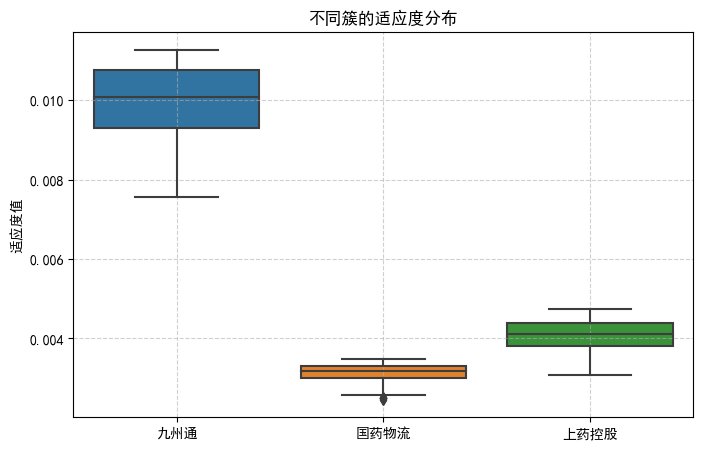

In [26]:
import seaborn as sns
# stable_f
center_name = center.配送中心
fitness_data = dict(zip(center_name, stable_f))

# 计算均值和标准差
for cluster, fitness_values in fitness_data.items():
    mean = np.mean(fitness_values)
    std = np.std(fitness_values)
    print(f"{cluster}: 均值 = {mean:.4f}, 标准差 = {std:.4f}")

# 绘制箱线图
plt.figure(figsize=(8, 5))
sns.boxplot(data=list(fitness_data.values()))
plt.xticks(range(len(fitness_data)), fitness_data.keys())
plt.ylabel("适应度")
plt.title("不同簇的适应度分布")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### 路线图

## 算法比较

### 与其它算法比较

In [21]:
import random
import math

# 模拟退火算法
def simulated_annealing_vrp(df, num_points, center_x, center_y, name):
    # 初始化温度和冷却率
    temperature = 1000
    cooling_rate = 0.99
    stopping_temperature = 1
    
    # 随机生成初始解
    current_solution = list(df.index)
    random.shuffle(current_solution)
    current_solution = np.array(current_solution)
    
    # 计算初始解的适应度值
    def fitness(solution):
        total_distance = 0
        current_capacity = 0
        current_point = (center_x, center_y)  # 配送中心
        
        for idx in solution:
            next_point = (df.loc[idx, 'X'], df.loc[idx, 'Y'])
            demand = df.loc[idx, 'demand']
            
            # 检查载重约束
            if current_capacity + demand > max_capacity:
                # 如果超出载重限制，返回到配送中心并重新开始
                total_distance += distance(current_point, (center_x, center_y))
                current_point = (center_x, center_y)
                current_capacity = 0
            
            total_distance += distance(current_point, next_point)
            current_point = next_point
            current_capacity += demand
        
        # 最后返回配送中心
        total_distance += distance(current_point, (center_x, center_y))
        
        return 1 / (1 + total_distance)
    
    current_fitness = fitness(current_solution)
    
    while temperature > stopping_temperature:
        # 生成新的解
        new_solution = current_solution.copy()
        i, j = random.sample(range(num_points), 2)
        new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
        
        # 计算新解的适应度值
        new_fitness = fitness(new_solution)
        
        # Metropolis准则
        if new_fitness > current_fitness or random.uniform(0, 1) < math.exp((new_fitness - current_fitness) / temperature):
            current_solution = new_solution
            current_fitness = new_fitness
        
        # 降低温度
        temperature *= cooling_rate
    
    # 输出最优解
    print(f"最优路径: {current_solution}")
    print(f"适应度值: {current_fitness}")
    print(f"配送中心: {name}")
    
    # 解析路径
    routes = parse_route(current_solution)
    print("车辆路径:")
    for i, route in enumerate(routes):
        print(f"子路径 {i+1}: {route}")
    
    return current_solution, current_fitness

# 调用模拟退火算法
for idx, frame in df.groupby('Cluster'):
    print('-' * 10)
    fn = simulated_annealing_vrp(frame, frame.shape[0], center.loc[idx, 'X'], center.loc[idx, 'Y'], center.loc[idx, '配送中心'])

----------
最优路径: [1809 4718 4648 4657 1918 3382 3823 4461 5102 5305 4012 1764 4811 2145]
适应度值: 0.004589181580983253
配送中心: 九州通
车辆路径:
子路径 1: [1809, 4718, 4648, 4657, 1918, 3382, 3823, 4461, 5102, 5305, 4012, 1764, 4811, 2145]
----------
最优路径: [3493 1555 4197 3862 4938   33 3890  638 4272 5389 3937 3050 4383 3062
  242 4195 4459 4671   84   79 3228 3080   15 1265  282  598  406    8
 5374 3054 4308  475 4793 4138  719  426  233  517 3131 1515 3178 3495
 3489 5001  169 4095  749]
适应度值: 0.0020721590247292166
配送中心: 国药物流
车辆路径:
子路径 1: [3493, 1555, 4197, 3862, 4938, 33, 3890, 638, 4272, 5389, 3937, 3050, 4383, 3062, 242, 4195, 4459, 4671, 84]
子路径 2: [79, 3228, 3080, 15, 1265, 282, 598, 406, 8, 5374, 3054, 4308, 475, 4793, 4138, 719, 426]
子路径 3: [233, 517, 3131, 1515, 3178, 3495, 3489, 5001, 169, 4095, 749]
----------
最优路径: [2397 1504 1396 4739 2345 5184 2472 2704 1567 3710 2676 3841 2918 3225
 4974 4425  293 1112  826 2842 4814 4918 3146 4017 1812 1758 2690 1816
 1513 4747 1649  726 2554 4024 4